<a href="https://colab.research.google.com/github/KJ22222/ESSA/blob/main/9_5%EC%9B%94_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3장 분류

* 3.1 MNIST

In [26]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')    

MNIST를 데이터셋 내려받는 코드

In [45]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [46]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

- 딕셔너리과 비슷한 구조

In [47]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [48]:
y.shape

(70000,)

- 70000개의 이미지,784(28*28)개의 특성

이미지 확인

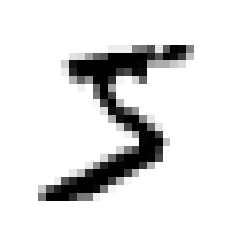

In [49]:
some_digit = X[0]

# reshape() 함수를 이용하여 28x28 모양의 2차원 어레이로 변환
some_digit_image = some_digit.reshape(28, 28)

# 흑백 이미지로 보여주기
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

실제 레이블

In [50]:
y[0]

'5'

In [51]:
y = y.astype(np.uint8)

숫자 이미지 출력 함수

In [35]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장: more_digits_plot


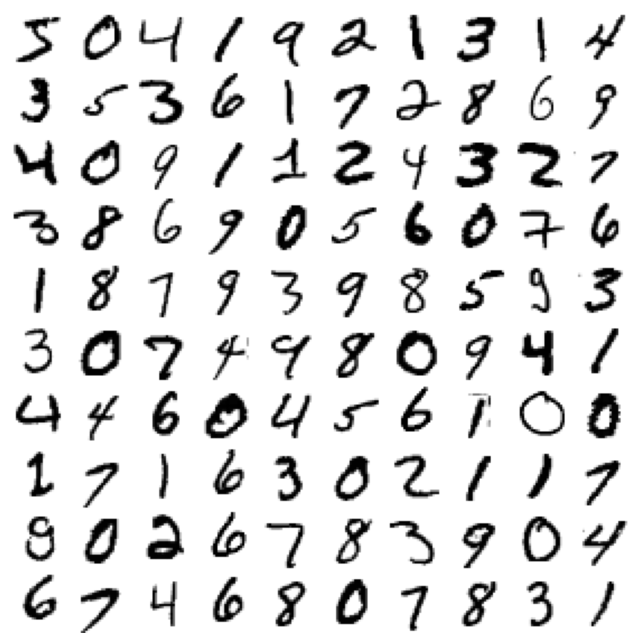

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

훈련 세트와 테스트 세트로 분류
- 이미 분류되어있음

In [52]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

- 3.2 이진 분류기
.

> 이미지가 숫자 5를 표현하는지 여부만을 판단하는 이진 분류기의 훈련을 위해 레이블을 0 또는 1로 변경한다.



In [53]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

하나의 분류 모델로 훈련시키기-확률적 경사 하강법(SGD)

In [54]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [55]:
sgd_clf.predict([some_digit])

array([ True])

- 3.3 성능 측정


-3.3.1 교차 검증을 사용한 정확도 측정

In [56]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

- 5아님 클래스를 분류하는 더미 분류기 만들기

In [57]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [58]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

-3.3.2 오차 행렬

In [59]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)

cm

array([[53892,   687],
       [ 1891,  3530]])



> - 행은 실제 열은 예측
- TN: 참 음성 개수. 즉, 5가 아닌 이미지를 5가 아니라고 정확하게 예측한 경우의 수
- FP: 거짓 양성 개수. 즉, 5가 아닌 이미지를 5라고 잘못 예측한 경우의 수
- FN: 거짓 음성 개수. 즉, 5를 나타내는 이미지를 5가 아니라고 잘못 예측한 경우의 수
- TP: 참 양성 개수. 즉, 5를 나타내는 이미지를 5라고 정확하게 예측한 경우의 수


-3.3.3 정밀도와 재현율

In [61]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [62]:
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [63]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [64]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

F1 점수 계산

In [65]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

-정밀도/재현율 트레이드오프


> - 결정 함수를 사용하여 각 샘플의 점수를 계산
  - 정밀도:맟춘거중에 정답
  - 재현율:전체 갯수중에 정답



In [66]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [67]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [68]:
y_some_digit_pred

array([ True])

임계값 높이기

In [69]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

적절한 임계값 구하기

In [70]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [71]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

임계값의 함수로 정밀도 재현율 그리기

In [72]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # 정밀도
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2) # 재현율

    # 그래프 설정
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])

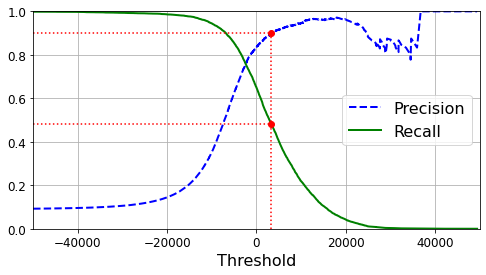

In [73]:
# 정밀도가 90%일 때의 재현율과 임계값 인덱스 반환
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                          
                                       
plt.show()

In [74]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [75]:
# 훈련 세트에 대한 정밀도가 90% 이상이 되도록 예측
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [76]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [77]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

-3.3.5 ROC 곡선


> 
  - 거짓 양성 비율에 대한 진짜 양성 비율 곡선
  - FPR은 1 - TNR(진짜 음성 비율)과 같다.
  - TNR을 특이도(specificity)라고도 한다.
  - 이에 ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프라고 할 수 있다.



In [78]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

그림 저장: roc_curve_plot


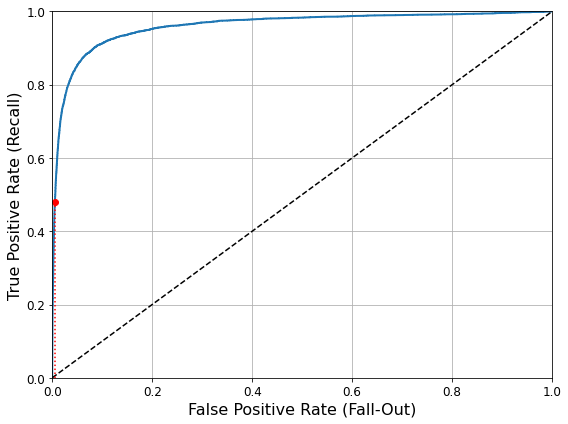

In [79]:
# SGD 분류기 모델의 TPR과 FPR 사이의 관계 그래프 그리기
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)

# 정밀도가 90%를 넘어설 때의 재현율(TPR, 참 양성 비율)에 해당하는 거짓 양성 비율(FPR)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]   # 0.0053 정도         
# 빨강 점과 원점 사이의 실선 그리기
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # 수직 빨강 점선. 좌표는 (0.0053, 0.48) 정도
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # y축과 빨강 점 사이의 수평 빨강 점선(거의 안보임))
plt.plot([fpr_90], [recall_90_precision], "ro")               # 빨강 점
save_fig("roc_curve_plot")                                  
plt.show()

- 좋은 분류기는 점선으로 최대한 멀리 떨어져 있어야 함

In [80]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

랜덤 포레스트 분류기
- predict_proba()메서드는 샘플이 행,클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담으 배열을 반환

In [81]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [82]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

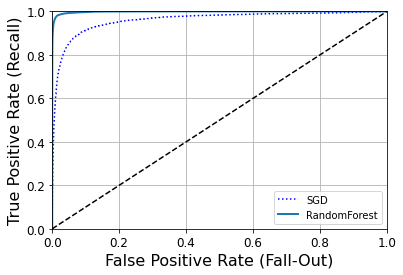

In [83]:
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForest')
plt.legend(loc = 'lower right')

plt.show()

- 3.4 다중 분류
 - 둘 이상의 클래스를 구별
 - 분류기의 결정 점수 중에서 가장 높은 것을 크래스로 선택->OvR 전략
 - 각 클래스 조합마다 이진 분류기를 훈련시키는 방법으로 0,1/0,2/1,2 이런식으로 분류->0v0 전략

In [85]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # 이제부터는 y_train_5 대신에 y_train 사용

SVC(gamma='auto', random_state=42)

In [87]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [88]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [89]:
np.argmax(some_digit_scores)

5

In [90]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [91]:
svm_clf.classes_[5]

5

일대다 방식 활용

In [92]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])   # 첫 1000개의 훈련 샘플만을 이용한 일대다 방식 진행

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [93]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [94]:
len(ovr_clf.estimators_)

10

In [95]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

- SGDClassifier와 RandomForestClassifier 분류기

In [96]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [97]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

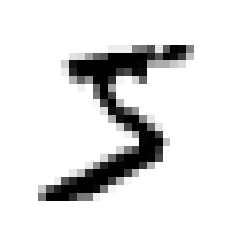

In [98]:
plot_digit(some_digit)

In [99]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [100]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [101]:
# 표준화 축척 조정 전처리 진행 후 SGD 분류기 훈련
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

- 3.5 에러 분석
 - 가능성이 높은 모델을 하나 찾았다고 가정하고 이모델의 성능을 향상시킬 방법 찾기

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

conf_mx

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(sgd_clf, X_train, y_train, include_values=False, cmap='gray')

오차율 행렬 활용

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # 숫자별 총 이미지 개수
norm_conf_mx = conf_mx / row_sums              # 숫자별 오차율 행렬

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)  # 대각선을 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]  # 3을 3으로 예측한 샘플들
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]  # 3을 5로 예측한 샘플들
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]  # 5를 3으로 예측한 샘플들
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]  # 5를 5로 예측한 샘플들

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)  # 이미지 상단 왼편
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)  # 이미지 상단 오른편
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)  # 이미지 하단 왼편
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)  # 이미지 하단 오른편
save_fig("error_analysis_digits_plot")
plt.show()

- 3.6 다중 레이블 분류
 - 같은 사진에 여러 사람이 등장하는 경우처럼 사람마다 꼬리표를 붙이는 경우

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

- 3.7 다중 출력 분류 
 - 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것 

In [ ]:
# MNIST 훈련 세트의 모든 샘플에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

# MNIST 테스트 세트의 모든 샘플에 잡음 추가
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# 레이블은 사진 원본
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0  # 0번 인덱스 

plt.subplot(121); plot_digit(X_test_mod[some_index])  # 잡음 추가된 이미지
plt.subplot(122); plot_digit(y_test_mod[some_index])  # 원본 이미지

save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)

In [ ]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")